In [1]:
import numpy as np
import batman
import matplotlib.pyplot as plt
import lightkurve as lk
from astropy.timeseries import LombScargle

def amplitude_spectrum(t, y, fmin=None, fmax=None, oversample_factor=10.0):
    
    tmax = t.max()
    tmin = t.min()
    df = 1.0 / (tmax - tmin)

    if fmin is None:
        fmin = df
    if fmax is None:
        fmax = 0.5 / np.median(np.diff(t))  # *nyq_mult

    freq = np.arange(fmin, fmax, df / oversample_factor)
    model = LombScargle(t, y)
    sc = model.power(freq, method="fast", normalization="psd")

    fct = np.sqrt(4.0 / len(t))
    amp = np.sqrt(sc) * fct

    return freq, amp

/home/daniel/anaconda3/lib/python3.8/site-packages/lightkurve/lightcurve.py:205: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  warnings.warn(
/home/daniel/anaconda3/lib/python3.8/site-packages/astropy/utils/decorators.py:535: LightkurveDeprecationWarning: "t0" was deprecated in version 2.0 and will be removed in a future version. Use argument "epoch_time" instead.
  return function(*args, **kwargs)


(-1.0, 1.0)

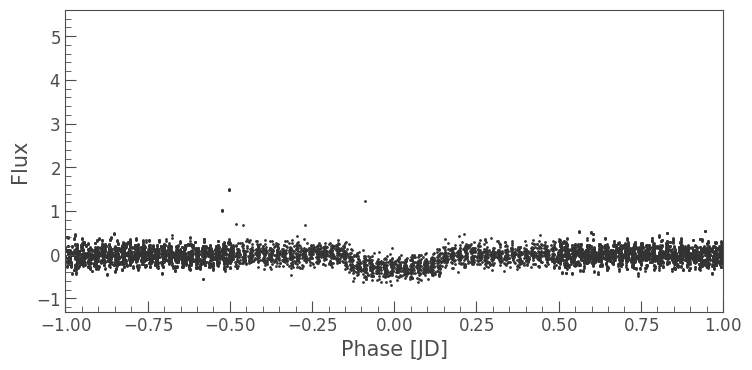

In [24]:
_, tce_time, tce_flux = np.loadtxt('plot.tbl', skiprows=3).T
tce_flux *= 1e3
lc_tce = lk.LightCurve(tce_time, tce_flux)
ax = lc_tce.fold(22.8245, t0=144.468).scatter()
ax.set_xlim(-1,1)

/home/daniel/anaconda3/lib/python3.8/site-packages/lightkurve/lightcurve.py:205: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  warnings.warn(
/home/daniel/anaconda3/lib/python3.8/site-packages/astropy/utils/decorators.py:535: LightkurveDeprecationWarning: "t0" was deprecated in version 2.0 and will be removed in a future version. Use argument "epoch_time" instead.
  return function(*args, **kwargs)


(-1.0, 1.0)

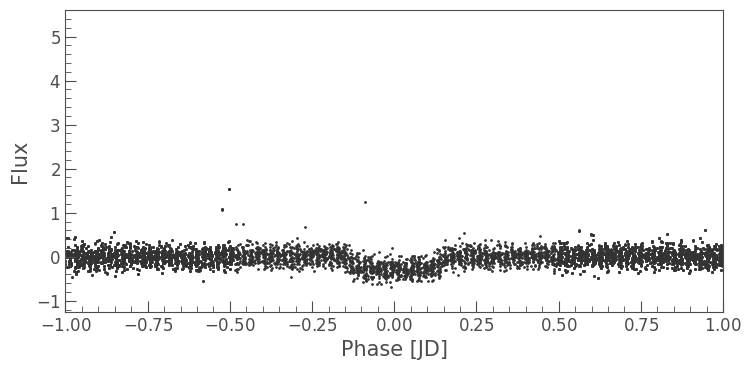

In [35]:
_, init_time, init_flux = np.loadtxt('plot_init.tbl', skiprows=3).T
init_flux *= 1e3
lc_init = lk.LightCurve(init_time, init_flux)
ax = lc_init.fold(22.8245, t0=144.468).scatter()
ax.set_xlim(-1,1)

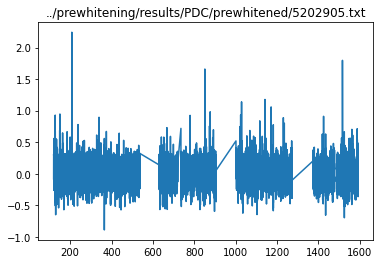

Text(0, 0.5, 'Amp [ppt]')

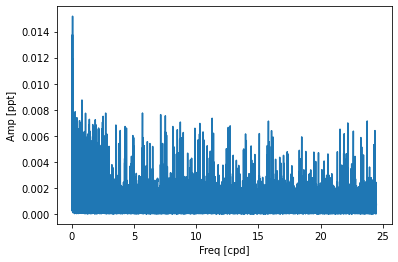

In [51]:
import glob
import numpy as np
# kplr009845898
# 220
# file = glob.glob('../data/lightcurves/spline corrected PDC/lc/*5202905*')[0]
file = glob.glob('../prewhitening/results/PDC/prewhitened/*5202905*')[0]
# file = glob.glob('prewhitening/results/BIC/*')[150]


time, flux, flux_err = np.loadtxt(file).T
# flux -= 1
# flux -= 1
# flux *= 1e3

time = np.ascontiguousarray(time)
plt.plot(time, flux)
plt.title(file)
plt.show()
plt.plot(*amplitude_spectrum(time, flux))
plt.xlabel('Freq [cpd]')
plt.ylabel('Amp [ppt]')

/home/daniel/anaconda3/lib/python3.8/site-packages/lightkurve/lightcurve.py:205: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  warnings.warn(
/home/daniel/anaconda3/lib/python3.8/site-packages/astropy/utils/decorators.py:535: LightkurveDeprecationWarning: "t0" was deprecated in version 2.0 and will be removed in a future version. Use argument "epoch_time" instead.
  return function(*args, **kwargs)
/home/daniel/anaconda3/lib/python3.8/site-packages/astropy/utils/decorators.py:535: LightkurveDeprecationWarning: "t0" was deprecated in version 2.0 and will be removed in a future version. Use argument "epoch_time" instead.
  return function(*args, **kwargs)


(-1.0, 1.0)

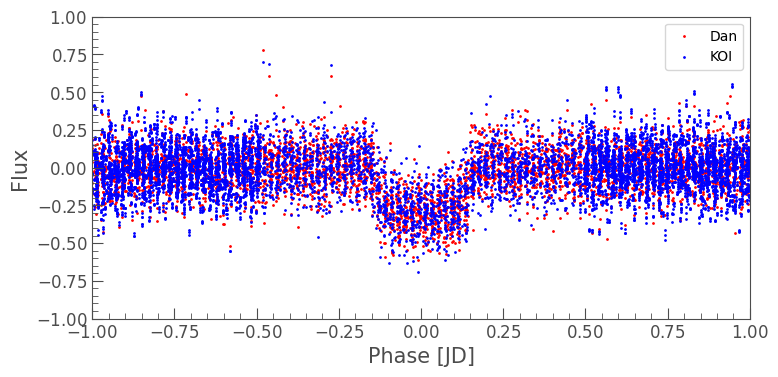

In [42]:
lc = lk.LightCurve(time, flux)
ax = lc.fold(22.8245, t0=144.468).scatter(c='red', label='Dan')
lc_tce.fold(22.8245, t0=144.468).scatter(ax=ax, c='blue', label='KOI')
# lc_init.fold(22.8245, t0=144.468).scatter(ax=ax, c='green')

plt.legend()
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)

/home/daniel/anaconda3/lib/python3.8/site-packages/astropy/utils/decorators.py:535: LightkurveDeprecationWarning: "t0" was deprecated in version 2.0 and will be removed in a future version. Use argument "epoch_time" instead.
  return function(*args, **kwargs)


<AxesSubplot:xlabel='Phase [JD]', ylabel='Flux'>

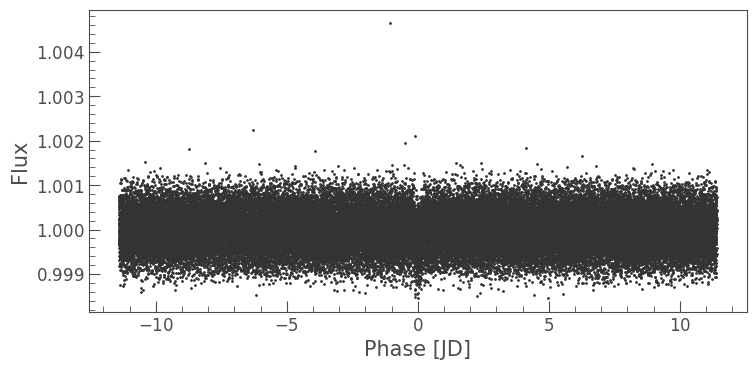

In [32]:
lc2.fold(22.8245, t0=144.468).scatter()

In [5]:
import astropy.units as u
(2 * u.R_earth).to(u.R_sun), (1 * u.R_jup).to(u.R_sun)

(<Quantity 0.01833578 solRad>, <Quantity 0.10276269 solRad>)

In [22]:
def generate_transit_model(time, period, rp, stellar_rad=1.7):
    params = batman.TransitParams()
    params.t0 = time[0]                 #time of inferior conjunction
    params.per = period                      #orbital period
    params.rp = rp                   #planet radius (in units of stellar radii)
    params.a = 30.                       #semi-major axis (in units of stellar radii)
    params.inc = np.degrees(np.arccos(0.5 * 1.7 / params.a))                     #orbital inclination (in degrees)
    params.ecc = 0.                    #eccentricity
    params.w = 90.                       #longitude of periastron (in degrees)
    params.u = [0.1, 0.3]                #limb darkening coefficients [u1, u2]
    params.limb_dark = "quadratic"   

    m = batman.TransitModel(params, time)    #initializes model
    batman_flux = m.light_curve(params) - 1
    return batman_flux

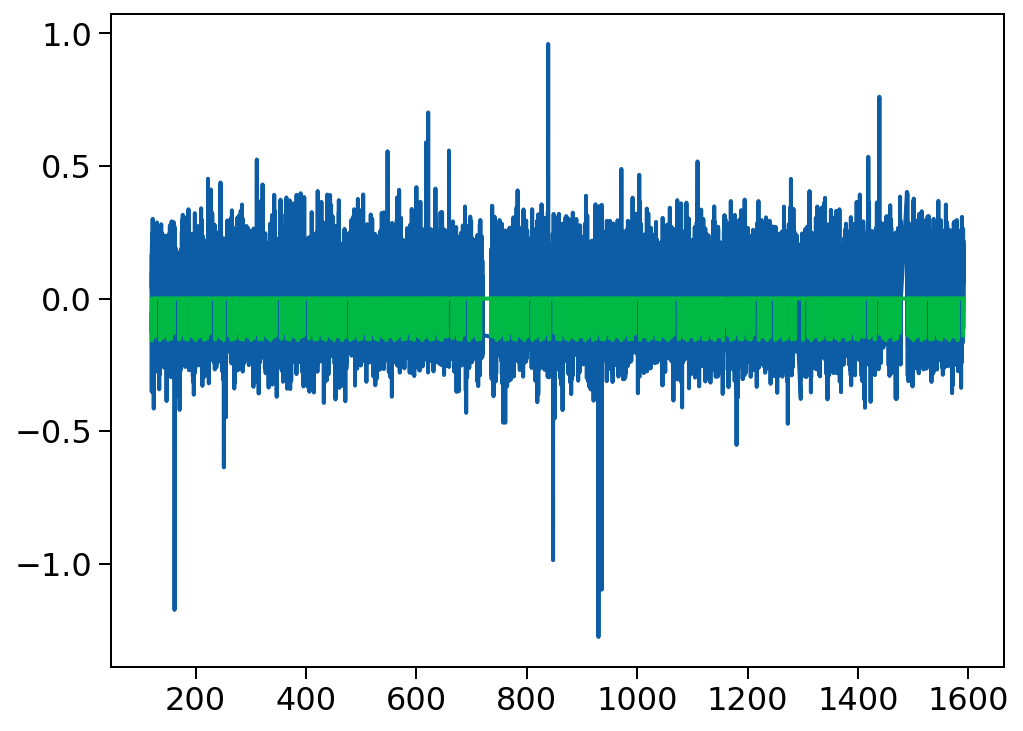

In [33]:
transit_model = generate_transit_model(time, 5., 0.5)
# total_flux = flux + transit_model
# plt.plot(time, total_flux)

plt.plot(time, flux)
plt.plot(time, transit_model)

total_flux = flux + transit_model

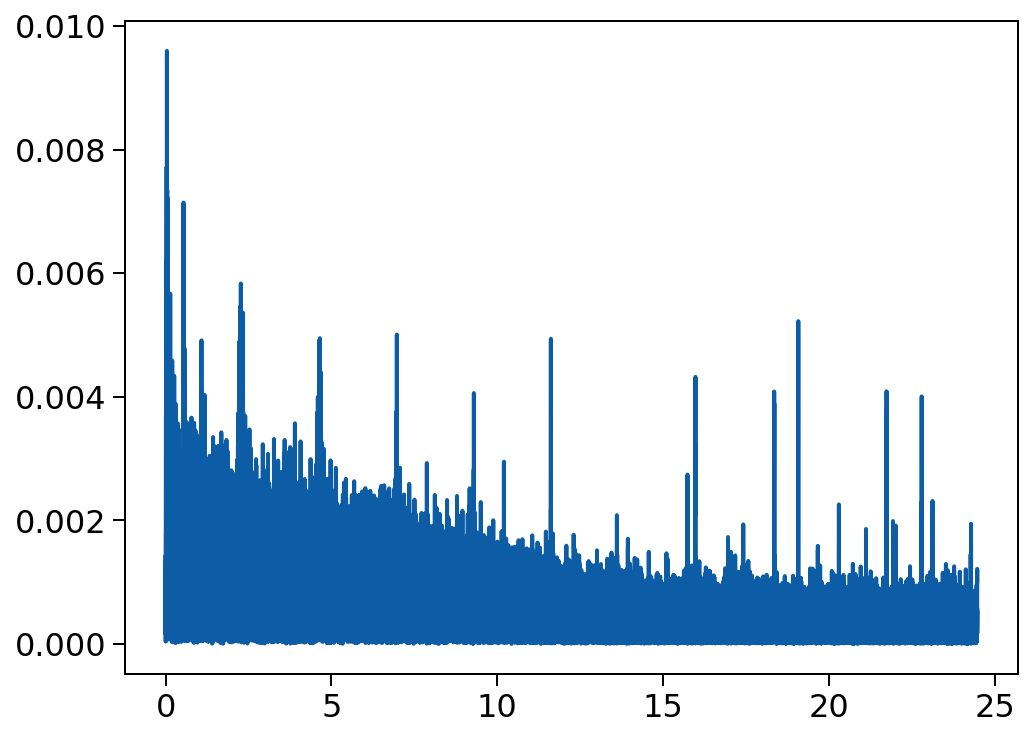

In [29]:
plt.plot(*amplitude_spectrum(time, total_flux))

In [34]:
from astropy.timeseries import BoxLeastSquares
from scipy.signal import savgol_filter

def smooth_lc(x, y, window_length=101, polyorder=3):
    m = np.ones(len(y), dtype=bool)
    for i in range(10):
        y_prime = np.interp(x, x[m], y[m])
        smooth = savgol_filter(y_prime, window_length, polyorder=polyorder)
        resid = y - smooth
        sigma = np.sqrt(np.mean(resid ** 2))
        m0 = np.abs(resid) < 3 * sigma
        if m.sum() == m0.sum():
            m = m0
            break
        m = m0
    return smooth

def bls_search(x, y, min_period=0.5, max_period=50, n_planets=1):
    m = np.zeros(len(x), dtype=bool)
    smooth = smooth_lc(x, y)
    period_grid = np.exp(np.linspace(np.log(min_period), np.log(max_period), 50000))
    bls_results = []
    periods = []
    t0s = []
    depths = []
    
    for i in range(n_planets):
        bls = BoxLeastSquares(x[~m], y[~m] - smooth[~m])
        bls_power = bls.power(period_grid, 0.1, oversample=20)
        bls_results.append(bls_power)

        # Save the highest peak as the planet candidate
        index = np.argmax(bls_power.power)
        periods.append(bls_power.period[index])
        t0s.append(bls_power.transit_time[index])
        depths.append(bls_power.depth[index])

        # Mask the data points that are in transit for this candidate
        m |= bls.transit_mask(x, periods[-1], 0.5, t0s[-1])
        
        
    fig, axes = plt.subplots(len(bls_results), 2, figsize=(15, 10))

    for i in range(len(bls_results)):
        # Plot the periodogram
        ax = axes[i]
        ax.axvline(np.log10(periods[i]), color="C1", lw=5, alpha=0.8)
        ax.plot(np.log10(bls_results[i].period), bls_results[i].power, "k")
        ax.annotate(
            "period = {0:.4f} d".format(periods[i]),
            (0, 1),
            xycoords="axes fraction",
            xytext=(5, -5),
            textcoords="offset points",
            va="top",
            ha="left",
            fontsize=12,
        )
        ax.set_ylabel("bls power")
        ax.set_yticks([])
        ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
        if i < len(bls_results) - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel("log10(period)")

        # Plot the folded transit
        ax = axes[i+1]
        p = periods[i]
        x_fold = (x - t0s[i] + 0.5 * p) % p - 0.5 * p
        m = np.abs(x_fold) < 0.4
        ax.plot(x_fold[m], y[m] - smooth[m], ".k")

        # Overplot the phase binned light curve
        bins = np.linspace(-0.41, 0.41, 32)
        denom, _ = np.histogram(x_fold, bins)
        num, _ = np.histogram(x_fold, bins, weights=y - smooth)
        denom[num == 0] = 1.0
        ax.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")

        ax.set_xlim(-0.4, 0.4)
        ax.set_ylabel("relative flux [ppt]")
        if i < len(bls_results) - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel("time since transit")

    fig.subplots_adjust(hspace=0.02)

    


In [35]:
plt.style.use('notebook')

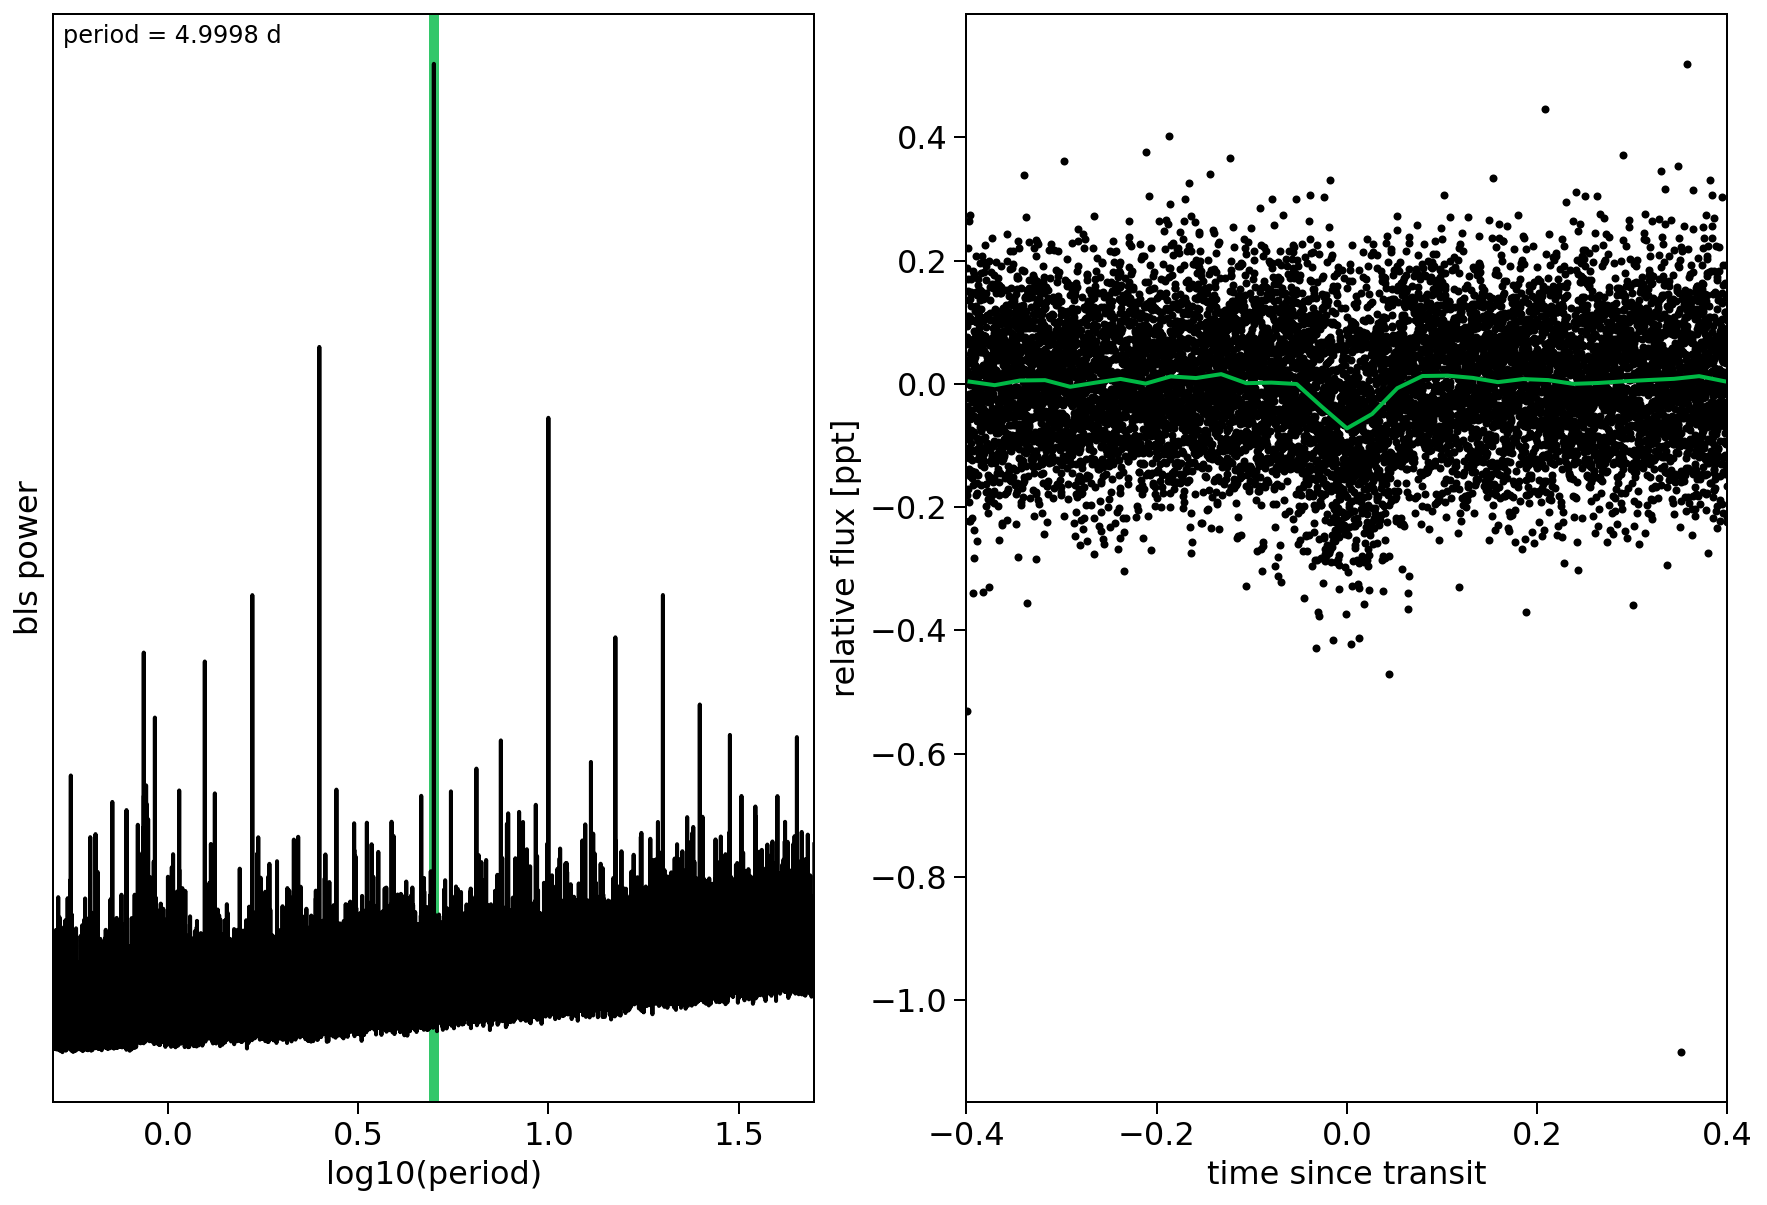

In [36]:
bls_search(time, 
          total_flux)

# plt.savefig('prewhitened.png')

In [ ]:
from astropy.timeseries import LombScargle
from scipy.optimize import curve_fit

def grad_model(time, freq, amp, phi):
    factor = 2 * np.pi * freq * time + phi
    return np.array([
        -2*np.pi*amp*time*np.sin(factor),
        np.cos(factor),
        -1 * amp * np.sin(factor)
    ]).T

def dft_phase(x, y, f):
    expo = 2.0 * np.pi * f * x
    ft_real = np.sum(y * np.cos(expo))
    ft_imag = np.sum(y * np.sin(expo))
    return np.arctan2(ft_imag, ft_real)

def model(time, freq, amp, phi):
    return amp * np.cos((2 * np.pi * freq * time) + phi)

def prewhiten(time, flux, fmin=1, fmax=None):
    theta = initialize_theta(time, flux, fmin, fmax)
    popt, _ = curve_fit(model, time, flux, p0=theta, jac=grad_model)
    return flux - model(time, *popt), popt, theta

# def prewhiten_test(time, flux, fmin=1, fmax=None):
#     theta = initialize_theta(time, flux, fmin, fmax)
#     return flux - model(time, *theta)

def find_highest_peak(f, a):
    """
    Find the frequency of the highest peak in the periodogram, using a
    3-point parabolic interpolation.
    """
    nu, p = f, a
    nu, p = np.atleast_1d(nu, p)

    # Get index of highest peak.
    imax = np.argmax(p)

    # Determine the frequency value by parabolic interpolation
    if imax == 0 or imax == p.size - 1:
        nu_peak = p[imax]
    else:
        # Get values around the maximum.
        frq1 = nu[imax-1]
        frq2 = nu[imax]
        frq3 = nu[imax+1]
        y1 = p[imax-1]
        y2 = p[imax]
        y3 = p[imax+1]

        # Parabolic interpolation formula.
        t1 = (y2-y3) * (frq2-frq1)**2 - (y2-y1) * (frq2-frq3)**2
        t2 = (y2-y3) * (frq2-frq1) - (y2-y1) * (frq2-frq3)
        nu_peak = frq2 - 0.5 * t1/t2
    return nu_peak

def estimate_background(x, y, log_width=0.05):
    count = np.zeros(len(x), dtype=int)
    bkg = np.zeros_like(x)
    x0 = np.log10(x[0])
    while x0 < np.log10(x[-1]):
        m = np.abs(np.log10(x) - x0) < log_width
        bkg[m] += np.median(y[m])
        count[m] += 1
        x0 += 0.5 * log_width
    return bkg / count

def initialize_theta(time, flux, fmin, fmax):
    f, a = amplitude_spectrum(time, flux, fmin=fmin, fmax=fmax, oversample_factor=5.)
    # Get freq of max power
    f0 = find_highest_peak(f, a)
    # Calculate a0 at f0
    a0 = np.sqrt(LombScargle(time, flux).power(f0, method="fast", normalization="psd")) * np.sqrt(4.0 / len(time))
    # Calculate phi0, since ASTC need to negative it
    phi0 = -1 * dft_phase(time, flux, f0)
    return f0, a0, phi0

In [81]:
n_components = 20

X = np.ascontiguousarray(np.nan_to_num(total_flux), np.float64)
X_flat = X.reshape(len(total_flux), -1) #turns three dimensional into two dimensional
f1 = np.reshape(X_flat, (len(X), -1))
X_pix = f1 #/ np.nansum(X_flat, axis=-1)[:, None]


In [82]:
X_pix

array([[-0.00170381],
       [-0.00260199],
       [-0.00374929],
       ...,
       [ 0.00524795],
       [-0.00084299],
       [ 0.00572801]])

In [83]:
ica = FastICA(n_components=10)
S_ = ica.fit_transform(X_pix)
A_ = ica.mixing_ #combine x_flat to get x
a = np.dot(S_.T, S_)
a[np.diag_indices_from(a)] += 1e-5
b = np.dot(S_.T, total_flux)
w = np.linalg.solve(a, b)
component_lcs = []
for i,s in enumerate(S_.T):
    component_lc = s * w[i]
    component_lcs.append(component_lc)

/home/daniel/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:469: UserWarning: n_components is too large: it will be set to 1
  % n_components


In [87]:
w

array([-0.48714338])